['Donor', 'Acceptor', 'Light source', 'Condition', 'Voc (V)', 'Jsc (mA cm^2)', 'FF(%)', 'PCE(%)', 'SMILES(donor)', 'SMILES(acceptor)', 'Donor_HOMO(ev)', 'Donor_LUMO(ev)', 'Donor_bandgap(ev)', 'Acceptor_HOMO(ev)', 'Acceptor_LUMO(ev)', 'Acceptor_bandgap(ev)', 'Reference', 'Unnamed: 17']
Index(['Donor', 'Acceptor', 'Light source', 'Condition', 'Voc (V)',
       'Jsc (mA cm^2)', 'FF(%)', 'PCE(%)', 'SMILES(donor)', 'SMILES(acceptor)',
       'Donor_HOMO(ev)', 'Donor_LUMO(ev)', 'Donor_bandgap(ev)',
       'Acceptor_HOMO(ev)', 'Acceptor_LUMO(ev)', 'Acceptor_bandgap(ev)',
       'Reference', 'Unnamed: 17'],
      dtype='object')
Acceptors PC61BM is missing from Excel sheet
Index(['Donor', 'Acceptor', 'Light source', 'Condition', 'Voc (V)',
       'Jsc (mA cm^2)', 'FF(%)', 'PCE(%)', 'SMILES(donor)', 'SMILES(acceptor)',
       'Donor_HOMO(ev)', 'Donor_LUMO(ev)', 'Donor_bandgap(ev)',
       'Acceptor_HOMO(ev)', 'Acceptor_LUMO(ev)', 'Acceptor_bandgap(ev)',
       'Reference', 'Unnamed: 17'],
     

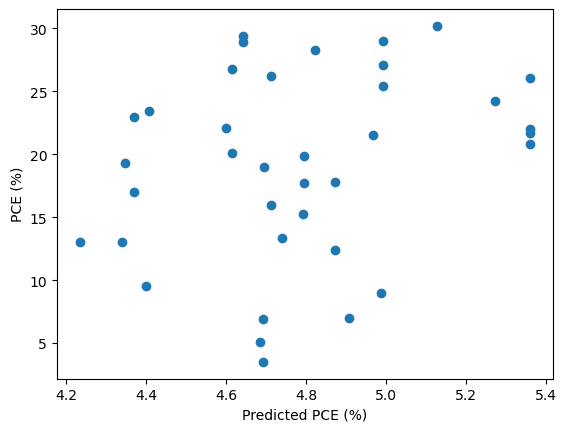

In [1]:
#!/usr/bin/env python

import pandas as pd
import numpy as np
# import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt



def get_row_data(df,mol_type,mol_name):
    filtered = df[df[mol_type] == mol_name]

    if filtered.empty:
        print(f'{mol_type} {mol_name} is missing from Excel sheet')
        return None
    else:
        return filtered.iloc[0].to_dict()

def get_don_acc_combined_features(don_homo,don_lumo,acc_lumo):
    edahl = acc_lumo - don_homo
    edall = don_lumo - acc_lumo
    return edahl, edall

def make_data(device_xlsx, donor_csv, acceptor_csv, normalize=False):
    # fdon = open(donor_csv)
    don_df = pd.read_csv(donor_csv)
    # don_df.columns = don_df.columns.str.strip()
    # donor_data = df.to_dict(df,orient='records')


    # fac = open(acceptor_csv)
    acc_df = pd.read_csv(acceptor_csv)
    # acc_df.columns = acc_df.columns.str.strip()
    # acceptor_data = df.to_dict(df,orient='records')
    
    # fdev =  open(device_xlsx) 
    df = pd.read_excel(device_xlsx)
    # df.columns = df.columns.str.strip()
    print(repr(df.columns.tolist()))  # Shows any hidden characters


    ndevices = len(df)
    X = np.zeros((ndevices,8))
    y = np.ones(ndevices) * -1.0

    seen_devices = set() #set of pairs of acceptor-donor pairs; avoids conflicting data points

    for k, row in df.iterrows():
        print(row.keys())
        donor = row['Donor'].strip()
        acceptor = row['Acceptor'].strip()
        device = (donor,acceptor)
        
        if device in seen_devices:
            print('Already saw ', device)
            continue
        
        seen_devices.add(device)

        don_data = get_row_data(don_df,'Donors', donor)
        acc_data = get_row_data(acc_df,'Acceptors', acceptor)

        if don_data is None or acc_data is None:
            continue

        don_homo = don_data['HOMO']
        don_lumo = don_data['LUMO']
        don_dhomo = don_homo - don_data['HOMO-1']
        don_dlumo = don_data['LUMO+1'] - don_lumo
        don_et1 = don_data['DET1']
        don_nd = don_data['Nd']
        
        acc_lumo = acc_data['LUMO']
        # adl = acc_data['LUMO+1'] - acc_lumo

        edahl, edall = get_don_acc_combined_features(don_homo,don_lumo,acc_lumo)

        X[k,0] = don_homo
        X[k,1] = don_lumo
        X[k,2] = don_et1
        X[k,3] = don_dhomo
        X[k,4] = don_dlumo
        X[k,5] = float(don_nd)
        X[k,6] = edahl
        X[k,7] = edall
        # X[k,8] = adl

        y[k] = row['PCE(%)']

    good_row_filter = y>=0 # True for rows with no missing data
    X = X[good_row_filter,:]
    y = y[good_row_filter]

    if normalize:
        X -= X.mean(axis=0)
        X /= X.std(axis=0)

    return X,y


device_xlsx = '/Users/nico/Desktop/scripts/OPVGCN/data/data-indoor.xlsx'
donor_csv = '/Users/nico/Desktop/scripts/OPVGCN/data/donors_emna_dft.csv'
acceptor_csv = '/Users/nico/Desktop/scripts/OPVGCN/data/acceptors_emna_dft.csv'
my_model_file = '/Users/nico/Desktop/scripts/OPVGCN/weights/lgb_nico'

X, ytrue = make_data(device_xlsx, donor_csv, acceptor_csv, normalize=True)
# model = lgb.Booster(model_file=my_model_file)
model = joblib.load(my_model_file)
ypred = model.predict(X)


plt.scatter(ypred,ytrue)
plt.xlabel('Predicted PCE (%)')
plt.ylabel('PCE (%)')
plt.show()